Each example is a self-contained block of code.

# [1] Calculate the hot and cold phase mass for each halo
Let's calculate the hot and cold bound mass for each halo.

## Load Snapshot

In [1]:
import numpy as np
from darepo.interfaces.arepo import ArepoSnapshot
path = "/data/cbyrohl/TNGdata/TNG50-4/output/snapdir_099/"
snap = ArepoSnapshot(path, catalog=path.replace("snapdir","groups"))

## Define temperature field

In [2]:
@snap.register_field("gas")
def Temperature(arrs, **kwargs):
    """ Compute gas temperature given (ElectronAbundance,InternalEnergy) in [K]. """
    xh = 0.76
    gamma = 5.0 / 3.0
    
    m_p = 1.672622e-24 # proton mass [g]
    k_B = 1.380650e-16 # boltzmann constant [erg/K]
    
    UnitEnergy_over_UnitMass = 1e10 # standard unit system (TODO: can obtain from snapshot)
    
    xe = arrs['ElectronAbundance']
    u_internal = arrs['InternalEnergy']
    
    mu = 4 / (1 + 3*xh + 4*xh*xe) * m_p
    temp = (gamma - 1.0) * u_internal / k_B * UnitEnergy_over_UnitMass * mu
    
    return temp

## Define operation to be performed on each halo
This operation will be done for each halo. We did not consider this for special subhalos lacking a clean design choice. If we want to operate on the first subhalo only, we just mask by the respective subhalo ID (e.g. equal to zero for the central subhalo) in the operation.

In [3]:
def calculate_hotcoldmass(Masses, Temperature, SubhaloID, parttype="PartType0",shape=(2,)):
    """Return gas mass above and below a temperature threshold Tthresh for the central subhalo."""
    Tthresh = 1e6 # K
    mask = SubhaloID==0
    if np.count_nonzero(mask)==0:
        return np.zeros(2)
    hotgas = np.where(Temperature>=Tthresh, Masses, 0)[mask].sum()
    coldgas = np.where(Temperature<Tthresh, Masses, 0)[mask].sum()
    return np.array([hotgas,coldgas])

masses = snap.map_halo_operation(calculate_hotcoldmass, chunksize=int(3e6), compute=True)

## Plot results
All data fields keep their code units. Temperature is calculated in Kelvin.

In [4]:
# Get Halo Mass to plot against
masses_h = snap.data["Group"]["GroupMass"].compute()

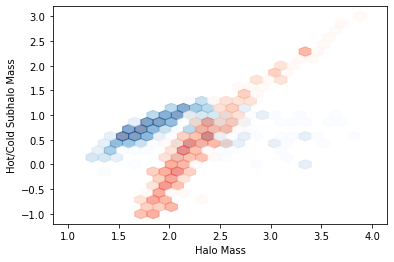

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
norm = LogNorm()
mask = (masses_h>0) & (masses[:,0]>0) & (masses[:,1]>0)
extent = [1,4,-1,3]
kwargs = dict(gridsize=25,alpha=0.5, norm=norm, extent=extent)
plt.hexbin(np.log10(masses_h[mask]), np.log10(masses[:,1][mask]), cmap="Blues", **kwargs)
plt.hexbin(np.log10(masses_h[mask]), np.log10(masses[:,0][mask]), cmap="Reds", **kwargs)
plt.xlabel("Halo Mass")
plt.ylabel("Hot/Cold Subhalo Mass")
plt.show()